# Simple IO with Embeddings

`topologic` contains extensive `embedding` and `clustering` packages for loading analyzing graphs

## Preconditions
Before we start, you should ensure you have the `matplotlib` library installed.

Below we show an example of how to extract an embedding from a graph.

In [1]:
%config IPCompleter.greedy=True

import networkx as nx
import topologic as tc
import matplotlib.pyplot as plt
import math
import random

# Data
To demonstrate the embedding functioanlity, we are using the network science author graph -- it can be found as a csv file under `test_data/netscience-authors.csv`.

Coauthorships in network science: coauthorship network of scientists working on network theory and experiment, as compiled by M. Newman in May 2006. A figure depicting the largest component of this network can be found here. M. E. J. Newman, Phys. Rev. E 74, 036104 (2006).

In [2]:
# load the graph data
edge_list_path = 'test_data/netscience-authors.csv'

with open(edge_list_path, 'r') as file:
    graph = tc.io.from_file(
        edge_csv_file=file,
        source_column_index=0,
        target_column_index=1,
        weight_column_index=2,
        edge_csv_has_headers=True
    )
    
len(graph.edges())

2742

# Introduction to Embeddings

An embedding is a mapping from an object, such as a word, to a vector in a lower dimensional space. For example, an embedding for words into a 3 dimensional space could look something like:

cat -   [0.015269641674978685,   0.013187535371066428,  0.0031715410923515153]

dog -   [0.014965873253211082,   0.0016122454341539472, 0.0035909807224411283]   

man -   [0.004237593168056164,   0.003526102334225012,  0.0030491193727161248]

woman - [0.0031461043909993824,  0.010022862663402465,  0.040323956479097034]

king -  [0.00013326964708904043, 0.001007046442967896,  6.510123655167899e-05]

queen - [0.0013619392422438148,  0.006342057672591439,  0.002270385097256966]

Embeddings are useful because it allows for the calculation of similarity between two objects. By calculating the cosine or Euclidian distance between two vectors in the embedding, you can determine the similarity between the two objects.

However, we will be generating network embeddings to facilitate the analysis of different graphs. When generating a network embedding, it is best practice to generate an embedding over each individual connected components. In this example, we are going to compute the embedding over the largest connected components.

In [3]:
graph = tc.largest_connected_component(graph)

len(graph.edges())

914

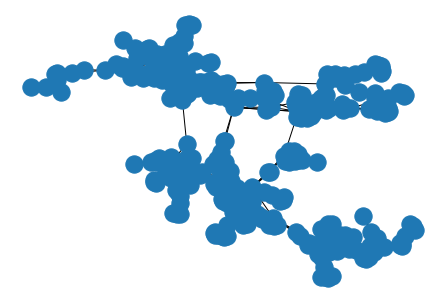

In [4]:
# generate a simple graph layout to visualize the graph using matplotlib.pyplot
layout = nx.spring_layout(graph, k=.5, iterations=500)
nx.draw(graph, pos=layout)
plt.show()

# Generate a laplacian spectral embedding

Generating a laplacian spectral embedding (LSE) is a single method call demonstrated below. `topologic` supports several embedding techniques that can be found in the `embedding` package.

The LSE is created using the eigendecomposition of the Laplacian matrix for a graph. Related, is the `adjacency_embedding` technique which performs the same computation except over the adjacency matrix of a graph.

The result of the embedding is a representation of the graph in an N-dimensional space; each node will have a vector of floats of length N. Since we are setting `maximum_dimensions` to 128, we will compute a LSE for the graph in 128 dimensions.

The return value of `laplacian_embedding` is an `embedding_container` which contains two arrays, one of the embedding and another that contains the vertex labels which are ids of the graph's vertices. A method that is often useful is `embedding_container.to_dictionary()` which will create a dictionary out of your embedding where the keys are vertex ids and the values are the vector for that vertex.

In [5]:
embedding_container = tc.embedding.laplacian_embedding(
    graph=graph,
    maximum_dimensions=128,
    elbow_cut=None # see api documentation for details on elbow cut
)

# will return a dictionary where the keys are node_ids and the values are a vector
embedding = embedding_container.to_dictionary()

print(f'Number of nodes in the graph {len(graph.nodes())} and number of nodes in the embedding {len(embedding.keys())}.')
print(f'The number of dimensions are {len(embedding_container.embedding[0])}.')

Number of nodes in the graph 379 and number of nodes in the embedding 379.
The number of dimensions are 128.


# Applications for the Embedding

Embeddings allow for distances to be computed in the embedded space instead of in the network space. Below, two examples will be shown.

The first is most_similar which will compute the most similar vertex for each vertex in the graph. NOTE: this implementation is naive and will be O(n^2) time complexity.

The second is a kmeans clustering of the nodes in the embedded space. `topologic` has an extensive clustering package in `embedding.clustering` which provides several different clustering techniques. For simple demonstration, kmeans will be used.


#### Comparison of Clustering Techniques

For a comprehensive comparison of different clustering techniques see the sklearn <a href="https://scikit-learn.org/stable/modules/clustering.html">documentation</a>.

In [6]:
# we chose cosine distance to measure the orientation of the vectors rather than the magnitude of the change
def most_similar(embedding, node_id):
    max_similarity = 0
    most_similar_node = ''
    for node in embedding.keys():
        if node != node_id:
            distance = tc.cosine_distance(embedding[node_id], embedding[node])
            if distance > max_similarity:
                max_similarity = distance
                most_similar_node = node
    
    return most_similar_node

# again, this is a linear operation applied per node -- this will be super slow on large graphs
for node in embedding.keys():
    print(f"{node}'s most similar author is {most_similar(embedding, node)}")       

ABEL H's most similar author is MENDOZA C
ABERG Y's most similar author is ARENAS A
ADLER J's most similar author is MARCHIORI M
AHARONY A's most similar author is LATORA V
ALAVA M's most similar author is KASKI K
ALBERT I's most similar author is DOBRIN R
ALBERT R's most similar author is MUNOZ M
ALEKSIEJUK A's most similar author is MARCHIORI M
ALLARIA E's most similar author is VALLADARES D
ALMAAS E's most similar author is PARK Y
AMANN A's most similar author is MAZA D
AMARAL L's most similar author is VANNUCCHI F
ANCELMEYERS L's most similar author is KUMAR S
ANDRADE J's most similar author is ARENAS A
ANTAL T's most similar author is PARK Y
ARAUJO A's most similar author is DIAMBRA L
ARECCHI F's most similar author is ZAKS M
ARENAS A's most similar author is SOFFER S
AYALI A's most similar author is KOVACS B
BAIESI M's most similar author is FRAUENFELDER H
BAK P's most similar author is RHO K
BALTHROP J's most similar author is KUMAR S
BANAVAR J's most similar author is LEONE M
B

KUNTZ P's most similar author is HOPCROFT J
KURTHS J's most similar author is HWANG D
LAHTINEN J's most similar author is ARAUJO A
LAI Y's most similar author is DOBRIN R
LAROSA M's most similar author is BUCOLO M
LATORA V's most similar author is MEYERORTMANNS H
LAWRENCE S's most similar author is GASTNER M
LEE D's most similar author is PARK H
LEICHT E's most similar author is HONG H
LEONE M's most similar author is SMITH E
LEYVRAZ F's most similar author is PARK Y
LILJEROS F's most similar author is GONZALES M
LILLO F's most similar author is MOSSA S
LINGJIANG K's most similar author is DEARCANGELIS L
LIU Z's most similar author is GREBOGI C
LLAS M's most similar author is GUIMERA R
LOFFREDO M's most similar author is GARLASCHELLI D
LOPEZRUIZ R's most similar author is MAZA D
LORETO V's most similar author is ZECCHINA R
LOUIS E's most similar author is TURTSCHI A
LOUNASMAA O's most similar author is FREUND H
LUSSEAU D's most similar author is MONTOYA J
MACDONALD P's most similar aut

In [7]:
clustering = tc.embedding.clustering.kmeans(
    embedding_container.embedding,
    n_clusters=18
)

# print all nodes in cluster 0, the first cluster
cluster_id = 0
for i in range(len(clustering)):
    if clustering[i] == cluster_id:
        print(embedding_container.vertex_labels[i])

CALDARELLI G
CAPOCCI A
COCCETTI F
MUNOZ M
PETERMANNN T


# Visualizing a graph using matplotlib

Another useful technique is to visualize a graph using metrics. `topologic` plays nicely with `networkx` and `matplotlib.pyplot`

Below is an example showing how you can use `topologic` to find the communities of a graph and then use `networkx` and `matplotlib` to render the graph.

In [8]:
communities = tc.partition.louvain(graph)

# use matplotlib to generate a color scheme for each node in the graph using its community
colors = []
for node in graph.nodes():
    colors.append(communities[node])

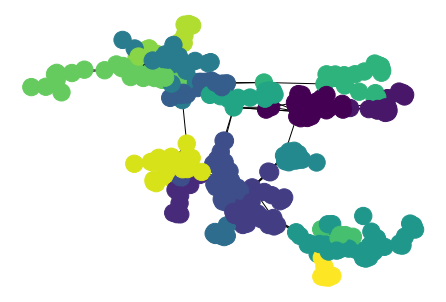

In [9]:
# draw with networkx and render with matplotlib.pyplot
nx.draw(graph, pos=layout, node_color=colors)
plt.show()

# For more information

<a href="https://en.wikipedia.org/wiki/Embedding">Embedding</a>

<a href="https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix">Eigendecompisition</a>

<a href="https://en.wikipedia.org/wiki/Spectral_clustering">Spectral Clustering</a>